Parâmetros

In [1]:
LOWER_CASE = False
MIN_GRAMS = 1
MAX_GRAMS = 1

Define a classe correta com base nos parâmetros tipo e categoria presentes em cada questão do dataset Chave

In [2]:
def correct_class(t, c):
    if c == 'COUNT':
        return 'MEASURE'
    if c == 'D' or c == 'DEFINITION':
        return 'DEFINITION'
    if c == 'F' or c == 'FACTOID':
        if t == 'COUNT':
            return 'MEASURE'
        else:
            return t
    if c == 'L' or c == 'LIST':
        if t == 'COUNT':
            return 'MEASURE'
        else:
            return t
    if c == 'LOCATION':
        return 'LOCATION'
    if c == 'MEASURE':
        return 'MEASURE'
    if c == 'OBJECT':
        return 'DEFINITION'
    if c == 'ORGANIZATION':
        return 'ORGANIZATION'
    if c == 'OTHER' and (t == 'FACTOID' or t == 'LIST'):
        return 'OTHER'
    if c == 'OTHER' and not (t == 'FACTOID' or t == 'LIST'):
        return t
    if c == 'PERSON' and t == 'DEFINITION':
        return 'DEFINITION'
    if c == 'PERSON' and not t == 'DEFINITION':
        return 'PERSON'
    if c == 'TIME':
        return 'TIME'
    return c

Realiza o pré-processamento no texto da questão

In [3]:
def pre_processing(text):
    if text is None:
        return None
    ret = text.replace('\n', '').replace('\t', '').replace('\r', '')
    ret = ret.replace('?', '')
    #ret = ret.replace('«', '\"').replace('»', '\"')
    return ret

Buscar dados do dataset Chave

In [4]:
import xml.etree.ElementTree as et
import qa_system
import re


path_questions = "data/questions.xml"

X, y = [], []
tree = et.parse(open(path_questions, 'r'))
for question in tree.getroot():
    
    t = question.attrib['tipo']
    c = question.attrib['categoria']
    clss = correct_class(t, c)
    
    if clss == None:
        continue
    if clss == 'X':
        continue
    if clss == 'MANNER':
        continue
    if clss == 'OBJECT':
        continue
    
    for t in question:
        if t.tag == 'texto':
            text = pre_processing(t.text)
            if text is not None:
                text = text.split()
                if type(text) == type(''): text = text.decode('utf-8')
                X.append(text)
                y.append(clss)
                break
        
print 'X:',len(X),' y:',len(y)

X: 3464  y: 3464


Modelos de EmbeddingVectorizer

In [139]:
import numpy as np
from collections import Counter, defaultdict


class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.itervalues().next())
    
    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec, LOWER=False):
        self.word2vec = word2vec
        self.word2weight = None
        self.lower = LOWER
        self.dim = len(word2vec.itervalues().next())
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x, strip_accents=None, ngram_range=(MIN_GRAMS, MAX_GRAMS), token_pattern=u'(?u)\\b\\w+\\b', lowercase=self.lower)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

def count_vectorizer(MIN_GRAM=1, MAX_GRAM=1, LOWER=False):
    return CountVectorizer(analyzer=lambda x: x, strip_accents=None, ngram_range=(MIN_GRAM, MAX_GRAM), token_pattern=u'(?u)\\b\\w+\\b', lowercase=LOWER)

def tfidf_vectorizer(MIN_GRAM=1, MAX_GRAM=1, LOWER=False):
    return TfidfVectorizer(analyzer=lambda x: x, strip_accents=None, ngram_range=(MIN_GRAM, MAX_GRAM), token_pattern=u'(?u)\\b\\w+\\b', lowercase=LOWER)

Carregar Modelos

In [37]:
import numpy as np
from gensim.models import KeyedVectors, Word2Vec

path_w2v_model = "data/word_embedding/pt.bin"

cbow_w2v_50 = 'data/word_embedding/cbow_s50_w2v.txt'
cbow_w2v_100 = 'data/word_embedding/cbow_s100_w2v.txt'
cbow_w2v_300 = 'data/word_embedding/cbow_s300_w2v.txt'
cbow_w2v_600 = 'data/word_embedding/cbow_s600_w2v.txt'

cbow_wng2v_50 = 'data/word_embedding/cbow_s50_wng2v.txt'
cbow_wng2v_100 = 'data/word_embedding/cbow_s100_wng2v.txt'
cbow_wng2v_300 = 'data/word_embedding/cbow_s300_wng2v.txt'

Carregar modelos Word2Vec em Português 

In [17]:
word2vec = Word2Vec.load(path_w2v_model)
word2vec.init_sims(replace=True)
w2v = {w: vec for w, vec in zip(word2vec.wv.index2word, word2vec.wv.syn0)}

In [11]:
w2v_50 = KeyedVectors.load_word2vec_format(cbow_w2v_50, unicode_errors="ignore")
w2v_50 = {w: vec for w, vec in zip(w2v_50.index2word, w2v_50.syn0)}

In [12]:
w2v_100 = KeyedVectors.load_word2vec_format(cbow_w2v_100, unicode_errors="ignore")
w2v_100 = {w: vec for w, vec in zip(w2v_100.index2word, w2v_100.syn0)}

In [45]:
w2v_300 = KeyedVectors.load_word2vec_format(cbow_w2v_300, unicode_errors="ignore")
w2v_300 = {w: vec for w, vec in zip(w2v_300.index2word, w2v_300.syn0)}

In [46]:
w2v_600 = KeyedVectors.load_word2vec_format(cbow_w2v_600, unicode_errors="ignore")
w2v_600 = {w: vec for w, vec in zip(w2v_600.index2word, w2v_600.syn0)}

In [13]:
wng2v_50 = KeyedVectors.load_word2vec_format(cbow_wng2v_50, unicode_errors="ignore")
wng2v_50 = {w: vec for w, vec in zip(wng2v_50.index2word, wng2v_50.syn0)}

In [14]:
wng2v_100 = KeyedVectors.load_word2vec_format(cbow_wng2v_100, unicode_errors="ignore")
wng2v_100 = {w: vec for w, vec in zip(wng2v_100.index2word, wng2v_100.syn0)}

In [52]:
wng2v_300 = KeyedVectors.load_word2vec_format(cbow_wng2v_300, unicode_errors="ignore")
wng2v_300 = {w: vec for w, vec in zip(wng2v_300.index2word, wng2v_300.syn0)}

Definindo os modelos de teste

In [90]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.cross_validation import cross_val_score

In [ ]:
all_results = []
all_models = []

In [91]:
def test_model(vector_model, classifer, cv=3):
    model = Pipeline([("vector_model", vector_model), ("classifer", classifer)])
    return cross_val_score(model, X, y, cv=cv).mean()

Naive Bayes

In [92]:
all_results.append(("NB mult", test_model(count_vectorizer(), MultinomialNB())))
all_results.append(("NB multt", test_model(tfidf_vectorizer(), MultinomialNB())))

In [93]:
all_results.append(("NB bern", test_model(count_vectorizer(), BernoulliNB())))
all_results.append(("NB bernt", test_model(tfidf_vectorizer(), BernoulliNB())))

SVM

In [137]:
all_results.append(("SVC", test_model(count_vectorizer(), SVC(kernel="linear"))))
all_results.append(("SVCt", test_model(tfidf_vectorizer(), SVC(kernel="linear"))))

In [133]:
all_results.append(("SVC rbf", test_model(count_vectorizer(), SVC(kernel="rbf", gamma=0.7))))
all_results.append(("SVC rbft", test_model(tfidf_vectorizer(), SVC(kernel="rbf", gamma=0.7))))

In [125]:
all_results.append(("SVC sigmoid", test_model(count_vectorizer(), SVC(kernel="sigmoid"))))
all_results.append(("SVC sigmoidt", test_model(tfidf_vectorizer(), SVC(kernel="sigmoid"))))

In [132]:
all_results.append(("SVC poly", test_model(count_vectorizer(), SVC(kernel="poly", gamma=0.7))))
all_results.append(("SVC polyt", test_model(tfidf_vectorizer(), SVC(kernel="poly", gamma=0.7))))

In [95]:
all_results.append(("SVC w2v", test_model(MeanEmbeddingVectorizer(w2v), SVC(kernel="linear"))))
all_results.append(("SVC w2vt", test_model(TfidfEmbeddingVectorizer(w2v), SVC(kernel="linear"))))

In [97]:
all_results.append(("SVC w2v50", test_model(MeanEmbeddingVectorizer(w2v_50), SVC(kernel="linear"))))
all_results.append(("SVC w2v50t", test_model(TfidfEmbeddingVectorizer(w2v_50), SVC(kernel="linear"))))

In [140]:
all_results.append(("SVC w2v100", test_model(MeanEmbeddingVectorizer(w2v_100), SVC(kernel="linear"))))
all_results.append(("SVC w2v100t", test_model(TfidfEmbeddingVectorizer(w2v_100), SVC(kernel="linear"))))

In [99]:
all_results.append(("SVC w2v300", test_model(MeanEmbeddingVectorizer(w2v_300), SVC(kernel="linear"))))
all_results.append(("SVC w2v300t", test_model(TfidfEmbeddingVectorizer(w2v_300), SVC(kernel="linear"))))

In [101]:
all_results.append(("SVC w2v600", test_model(MeanEmbeddingVectorizer(w2v_600), SVC(kernel="linear"))))
all_results.append(("SVC w2v600t", test_model(TfidfEmbeddingVectorizer(w2v_600), SVC(kernel="linear"))))

In [102]:
all_results.append(("SVC wn2v50", test_model(MeanEmbeddingVectorizer(wng2v_50), SVC(kernel="linear"))))
all_results.append(("SVC wn2v50t", test_model(TfidfEmbeddingVectorizer(wng2v_50), SVC(kernel="linear"))))

In [103]:
all_results.append(("SVC wn2v100", test_model(MeanEmbeddingVectorizer(wng2v_100), SVC(kernel="linear"))))
all_results.append(("SVC wn2v100t", test_model(TfidfEmbeddingVectorizer(wng2v_100), SVC(kernel="linear"))))

In [104]:
all_results.append(("SVC wn2v300", test_model(MeanEmbeddingVectorizer(wng2v_300), SVC(kernel="linear"))))
all_results.append(("SVC wn2v300t", test_model(TfidfEmbeddingVectorizer(wng2v_300), SVC(kernel="linear"))))

ExtraTrees

In [106]:
all_results.append(("et", test_model(count_vectorizer(), ExtraTreesClassifier(n_estimators=200))))
all_results.append(("ett", test_model(tfidf_vectorizer(), ExtraTreesClassifier(n_estimators=200))))

In [107]:
all_results.append(("et w2v", test_model(MeanEmbeddingVectorizer(w2v), ExtraTreesClassifier(n_estimators=200))))
all_results.append(("et w2vt", test_model(TfidfEmbeddingVectorizer(w2v), ExtraTreesClassifier(n_estimators=200))))

In [109]:
all_results.append(("et w2v100", test_model(MeanEmbeddingVectorizer(w2v_100), ExtraTreesClassifier(n_estimators=200))))
all_results.append(("et w2v100t", test_model(TfidfEmbeddingVectorizer(w2v_100), ExtraTreesClassifier(n_estimators=200))))

In [110]:
all_results.append(("et w2v300", test_mall_resultsodel(MeanEmbeddingVectorizer(w2v_300), ExtraTreesClassifier(n_estimators=200))))
all_results.append(("et w2v300t", test_model(TfidfEmbeddingVectorizer(w2v_300), ExtraTreesClassifier(n_estimators=200))))

In [117]:
all_results.append(("et wn2v100", test_model(MeanEmbeddingVectorizer(wng2v_100), ExtraTreesClassifier(n_estimators=200))))
all_results.append(("et wn2v100t", test_model(TfidfEmbeddingVectorizer(wng2v_100), ExtraTreesClassifier(n_estimators=200))))

In [118]:
all_results.append(("et wn2v300", test_model(MeanEmbeddingVectorizer(wng2v_300), ExtraTreesClassifier(n_estimators=200))))
all_results.append(("et wn2v300t", test_model(TfidfEmbeddingVectorizer(wng2v_300), ExtraTreesClassifier(n_estimators=200))))

Obter resultados

model                score
-----------------  -------
SVC                 0.8204
SVC lower           0.8204
SVCt                0.8172
SVCt lower          0.8172
et                  0.8086
ett                 0.7982
SVC rbft            0.7935
NB mult             0.7629
NB multt            0.7424
SVC w2v600          0.7297
SVC w2v300          0.7254
SVC wn2v300         0.7251
SVC wn2v100         0.7075
SVC w2vt            0.7006
SVC w2v100          0.6939
SVC w2v             0.6823
SVC wn2v50          0.6809
et w2v300           0.6775
SVC w2v600t         0.6760
et w2v              0.6746
et w2v100           0.6714
et w2vt             0.6708
et wn2v300          0.6702
et wn2v100          0.6700
SVC wn2v300t        0.6677
SVC wn2v50t         0.6601
et wn2v100t         0.6587
SVC wn2v100t        0.6576
et w2v100t          0.6546
SVC w2v100t         0.6527
SVC w2v100t lower   0.6527
SVC w2v300t         0.6521
et wn2v300t         0.6506
et w2v300t          0.6477
SVC w2v50           0.6411
S

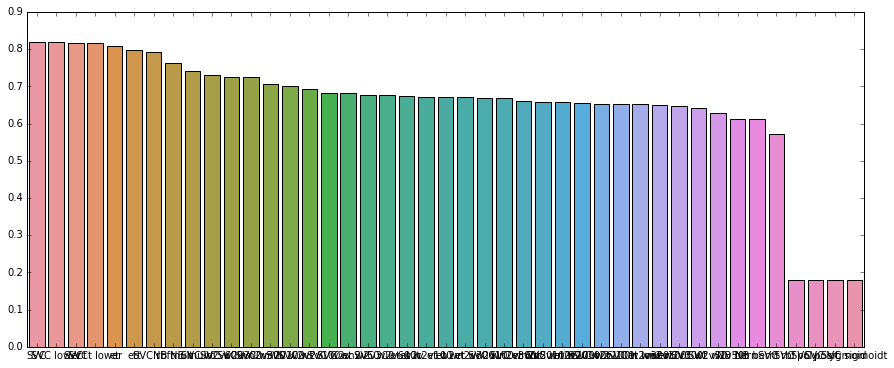

In [141]:
from tabulate import tabulate
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

scores = sorted([(name, result) 
                 for name, result in all_results], 
                key=lambda (_, x): -x)

print tabulate(scores, floatfmt=".4f", headers=("model", 'score'))
plt.figure(figsize=(15, 6))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores])

Realizar testes variando o tamanho do conjunto de treinamento

In [ ]:
from sklearn.cross_validation import StratifiedShuffleSplit

def benchmark(model, X, y, n):
    test_size = 1 - (n / float(len(y)))
    scores = []
    for train, test in StratifiedShuffleSplit(y, n_iter=5, test_size=test_size):
        for t in train: print type(t)
        print X[train]
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        scores.append(accuracy_score(model.fit(X_train, y_train).predict(X_test), y_test))
    return np.mean(scores)

In [ ]:
train_sizes = [10, 40, 160, 640, 3200]
table = []
for name, model in all_models:
    for n in train_sizes:
        table.append({'model': name, 
                      'accuracy': benchmark(model, X, y, n), 
                      'train_size': n})
df = pd.DataFrame(table)


Plotar gráfico

In [ ]:
plt.figure(figsize=(15, 6))
fig = sns.pointplot(x='train_size', y='accuracy', hue='model', 
                    data=df[df.model.map(lambda x: x in ["mult_nb", "svc_tfidf", "w2v_tfidf", 
                                                         "glove_small_tfidf", "glove_big_tfidf", 
                                                        ])])
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="accuracy")
fig.set(xlabel="labeled training examples")
fig.set(title="R8 benchmark")
fig.set(ylabel="accuracy")